In [1]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    with open(path) as f:
        return json.load(f)


no_cont_data_16 = load_data('/data/ges/clipper/inception_tXP_SMP_no_cont/tXP_inception_16-180609_091117.json')
cont_data_16 = load_data('/data/ges/clipper/inception_SMP_contention/tXP.model-inception.contention-1000.batch-16.contention_gpu_batch-32.contention_cpu_batch-1-180609_092504.json')

In [2]:
def plot_throughputs(data, **kwargs):
    thru_trial_rates = [item['meters'][0]['inception:prediction_throughput']['rate'] for item in data['throughput_results']['client_metrics']]
    thru_trial_rates = [float(x) for x in thru_trial_rates]
    plt.scatter(np.arange(len(thru_trial_rates)), thru_trial_rates, **kwargs)
    
def plot_latencies(data, **kwargs):
    no_cont_inception_responses = np.asarray([[d['container::send'], d['container::send'] - d['container::recv']] for d in data["throughput_results"]["lineage"]])
    print "mean: {}".format(np.mean(no_cont_inception_responses[1:,1]/1000.))
    sns.distplot(no_cont_inception_responses[1:,1]/1000., **kwargs)

In [ ]:
plot_throughputs(no_cont_data_16, label="No contention")
plot_throughputs(cont_data_16, label="With contention")
plt.legend()

In [ ]:
plot_latencies(no_cont_data_16, label="No contention")
plot_latencies(cont_data_16, label="With contention")
plt.legend()

In [24]:
no_cont_data_32 = load_data('/data/ges/clipper/inception_tXP_SMP_no_cont/tXP_inception_32-180609_095951.json')
cont_data_32 = load_data('/data/ges/clipper/inception_SMP_contention/tXP.model-inception.contention-1000.batch-32.contention_gpu_batch-32.contention_cpu_batch-1-180614_114222.json')
no_op_cont_data_32 = load_data('/data/ges/clipper/inception_SMP_contention/tXP.model-inception.contention-1000.batch-32.contention_gpu_batch-32.contention_cpu_batch-1-180614_142227.json')
clipper_inception_expanded_cont_data_32 = load_data('/data/ges/clipper/inception_SMP_contention/tXP.model-inception.contention-1000.batch-32.contention_gpu_batch-32.contention_cpu_batch-1-180614_160949.json')
clipper_expanded_cont_data_32 = load_data('/data/ges/clipper/inception_SMP_contention/tXP.model-inception.contention-1000.batch-32.contention_gpu_batch-32.contention_cpu_batch-1-180614_162506.json')

In [211]:
no_op_cont_data_32["throughput_results"]["lineage"][0]

{u'clipper::frontend_rpc_recv': 1528654383753706,
 u'clipper::frontend_rpc_response_send': 1528654383820571,
 u'clipper::rpc_recv': 1528654383820535,
 u'clipper::sent_rpc': 1528654383753797,
 u'clipper::task_dequeued': 1528654383753774,
 u'clipper::task_enqueued': 1528654383753720,
 u'clipper::task_executor_msg_callback_found': 1528654383820564,
 u'clipper::task_executor_recv': 1528654383820546,
 u'clipper::task_executor_recv_end': 1528654383820562,
 u'clipper::zmq_frontend_response_callback': 1528654383820565,
 u'container::after_predict': 1528654383819806,
 u'container::before_predict': 1528654383760191,
 u'container::recv': 1528654383755449,
 u'container::send': 1528654383820089,
 u'driver::recv': 1528654381411262,
 u'driver::send': 1528654381238174}

mean: 149.997135943
mean: 151.563013934
0.989668468907


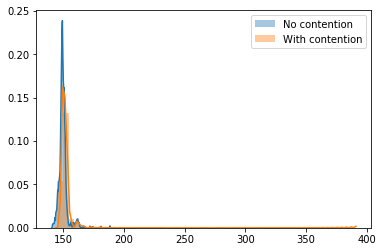

In [208]:
plot_latencies(no_cont_data_32, label="No contention")
plot_latencies(no_print_cont_data_32, label="With contention")
print 149.997135943 / 151.563013934
plt.legend()

In [19]:
def plot_clipper_stages(data_list, suptitle = None):
    lineages_list = [d["throughput_results"]["lineage"] for d in data_list]
    def get_stage(stage_name, lineages):
        return np.asarray([[d[stage_name] for d in lineages]]).flatten()
    stages = [
        "clipper::frontend_rpc_recv",
        "clipper::task_enqueued",
        "clipper::task_dequeued",
        "clipper::sent_rpc",
        "container::recv",
        "container::before_predict",
        "container::after_predict",
        "container::send",
        "clipper::rpc_recv",
        "clipper::task_executor_recv",
        "clipper::task_executor_recv_end",
        "clipper::task_executor_msg_callback_found",
        "clipper::zmq_frontend_response_callback",
        "clipper::frontend_rpc_response_send"
    ]
    plt.figure(figsize=(10*len(data_list),40))
    plt.suptitle(suptitle, fontsize=16)
    for i in range(len(stages)-1):
        first_stage = stages[i]
        second_stage = stages[i+1]
        max_y = 0
        min_y = np.inf
        for j, lineages in enumerate(lineages_list):
            values = get_stage(second_stage, lineages) - get_stage(first_stage, lineages)
            max_y = max(max_y, np.max(values))
            min_y = min(min_y, np.min(values))
        for j, lineages in enumerate(lineages_list):
            plt.subplot(len(stages)-1,len(data_list),i*len(data_list)+j+1)
            plt.ylim([min_y/1000., max_y/1000.])
            plt.title("{} -> {}".format(first_stage, second_stage))
            plt.ylabel("Time (ms)")
            plt.plot(np.arange(len(lineages)), (get_stage(second_stage, lineages) - get_stage(first_stage, lineages))/1000.)

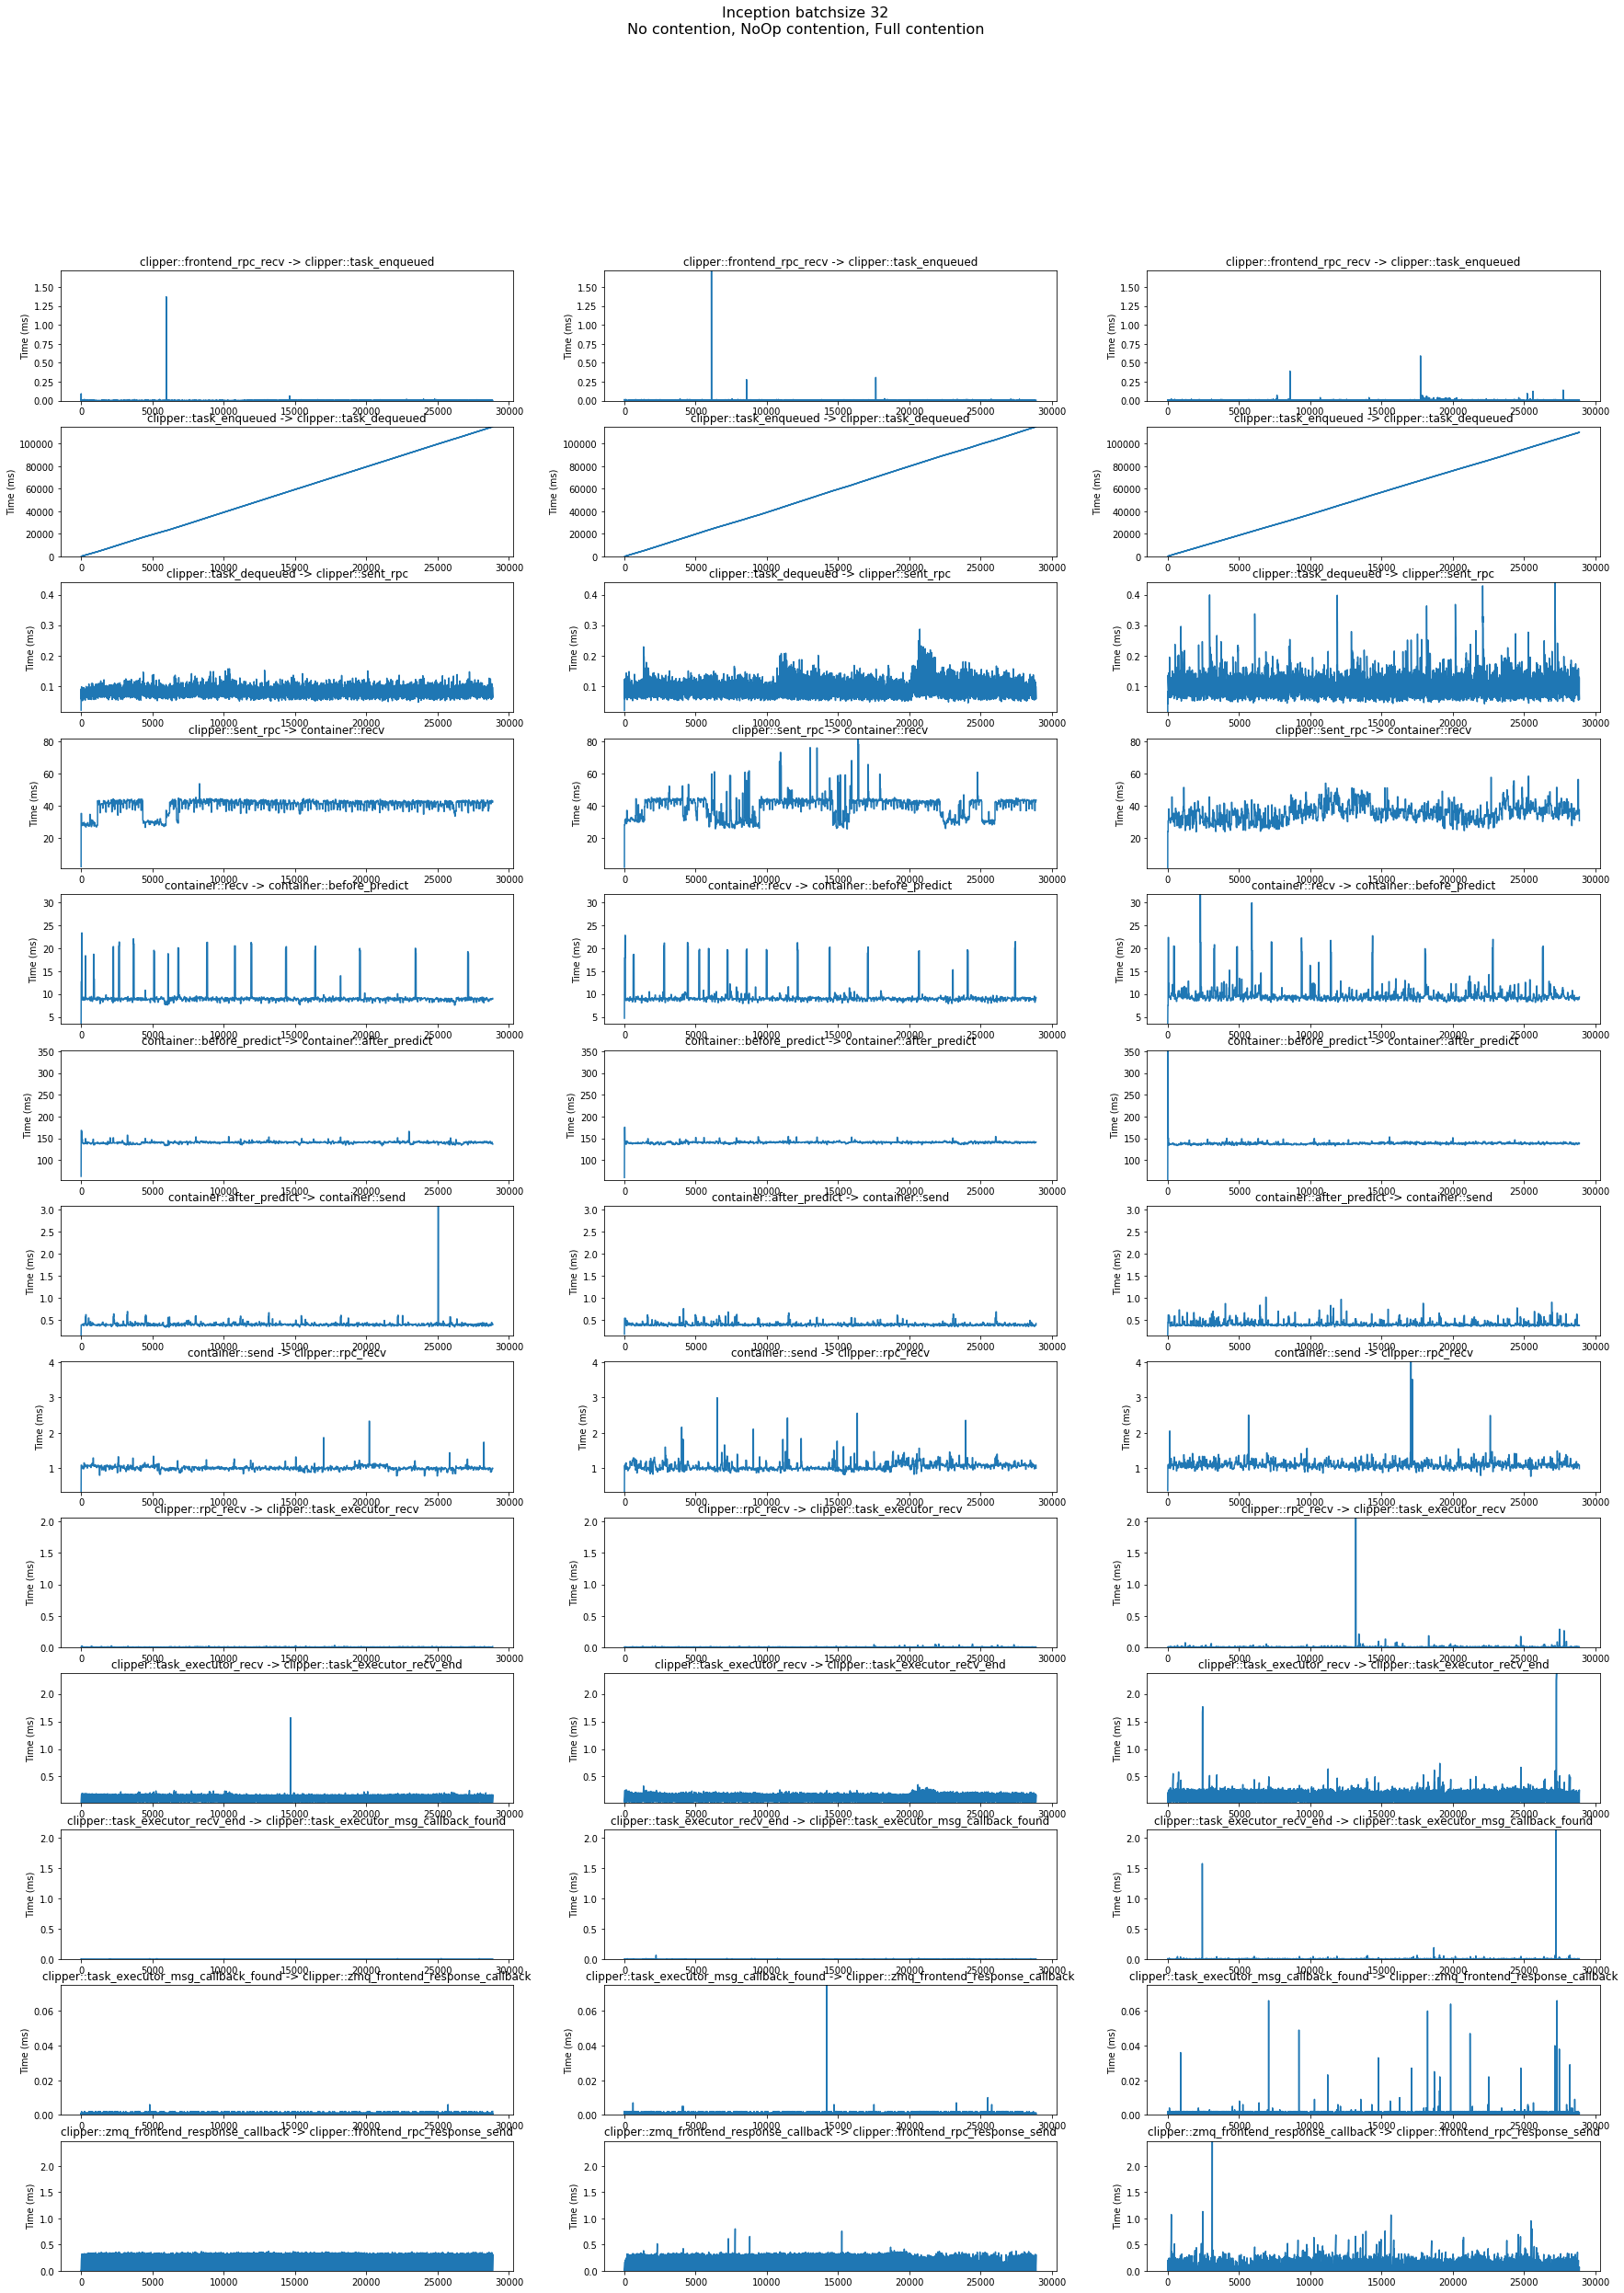

In [28]:
plot_clipper_stages([no_cont_data_32, no_op_cont_data_32, clipper_expanded_cont_data_32], "Inception batchsize 32\nNo contention, NoOp contention, Full contention")